## Pandas analysis

This exercise consists in analyzing a dataset containg timing information from a series of Time-to-Digital-Converters (TDC) implemented in a couple of FPGAs. Each measurement (i.e. each row of the input file) consists of a flag that specifies the type of message ('HEAD', which in this case is always 1), two addresses of the TDC providing the signal ('FPGA' and 'TDC_CHANNEL'), and the timing information ('ORBIT_CNT', 'BX_COUNTER', and 'TDC_MEAS'). Each TDC count corresponds to 25/30 ns, whereas a unit of BX_COUNTER corresponds to 25 ns, and the ORBIT_CNT is increased every 'x' BX_COUNTER. This allows to store the time in a similar way to hours, minutes and seconds.

In [14]:
# If you didn't download it yet, please get the relevant file now!
!wget https://www.dropbox.com/s/xvjzaxzz3ysphme/data_000637.txt -P ~/data/

--2024-01-21 11:59:48--  https://www.dropbox.com/s/xvjzaxzz3ysphme/data_000637.txt


Risoluzione di www.dropbox.com (www.dropbox.com)... 162.125.69.18
Connessione a www.dropbox.com (www.dropbox.com)|162.125.69.18|:443... connesso.
Richiesta HTTP inviata, in attesa di risposta... 302 Found
Posizione: /s/raw/xvjzaxzz3ysphme/data_000637.txt [segue]
--2024-01-21 11:59:48--  https://www.dropbox.com/s/raw/xvjzaxzz3ysphme/data_000637.txt
Riutilizzo della connessione esistente a www.dropbox.com:443.
Richiesta HTTP inviata, in attesa di risposta... 302 Found
Posizione: https://ucf317f1da558bdeca7c1c5340cc.dl.dropboxusercontent.com/cd/0/inline/CLy5tznrv7B1HLVWVje3TmTm7HRls0_x4CujJeLU-vcOjP0dHZ4BrH8YFrh0_WDJ4MuRyFdcy_MwLeqJ0AHcHLhMJ_bk7O9ugjksq6fnQx7dPJlYzPGsepfF97kP3OCwKxA/file# [segue]
--2024-01-21 11:59:49--  https://ucf317f1da558bdeca7c1c5340cc.dl.dropboxusercontent.com/cd/0/inline/CLy5tznrv7B1HLVWVje3TmTm7HRls0_x4CujJeLU-vcOjP0dHZ4BrH8YFrh0_WDJ4MuRyFdcy_MwLeqJ0AHcHLhMJ_bk7O9ugjksq6fnQx7dPJlYzPGsepfF97kP3OCwKxA/file
Risoluzione di ucf317f1da558bdeca7c1c5340cc.dl.dropboxuserco

1\. Create a Pandas DataFrame reading N rows of the 'data_000637.txt' dataset. Choose N to be smaller than or equal to the maximum number of rows and larger that 10k.

2\. Find out the number of BX in a ORBIT (the value 'x').

3\. Find out how much the data taking lasted. You can either make an estimate based on the fraction of the measurements (rows) you read, or perform this check precisely by reading out the whole dataset.

4\. Create a new column with the absolute time in ns (as a combination of the other three columns with timing information).

5\. Replace the values (all 1) of the HEAD column randomly with 0 or 1.

6\. Create a new DataFrame that contains only the rows with HEAD=1.

7\. Make two occupancy plots (one for each FPGA), i.e. plot the number of counts per TDC channel

8\. Use the groupby method to find out the noisy channels, i.e. the TDC channels with most counts (say the top 3)

9\. Count the number of unique orbits. Count the number of unique orbits with at least one measurement from TDC_CHANNEL=139

In [24]:
import pandas as pd
import numpy as np
import seaborn as sns
import numpy.random as npr
import matplotlib.pyplot as plt

In [16]:
npr.seed(2104271)

#### 1)

In [17]:
N = 1e5
file_name = "~/data/data_000637.txt"

# create dataframe
data = pd.read_csv(file_name, nrows = N)
print(data.head(), '\n')

   HEAD  FPGA  TDC_CHANNEL   ORBIT_CNT  BX_COUNTER  TDC_MEAS
0     1     0          123  3869200167        2374        26
1     1     0          124  3869200167        2374        27
2     1     0           63  3869200167        2553        28
3     1     0           64  3869200167        2558        19
4     1     0           64  3869200167        2760        25 



#### 2)

In [18]:
# number of bx in a orbit
bx = data['BX_COUNTER'].max()
print('The number of BX in a orbit is:', bx + 1, '\n')

The number of BX in a orbit is: 3564 



#### 3)

In [19]:
# how much the data taking lasted
tdc_count = 25/30   # ns
bx_unit = 25    # ns

data = data.sort_values(by = ['ORBIT_CNT', 'BX_COUNTER', 'TDC_MEAS'], ascending = True)
start = data.iloc[0]['TDC_MEAS'] * tdc_count + data.iloc[0]['BX_COUNTER'] * bx_unit + data.iloc[0]['ORBIT_CNT'] * bx * bx_unit
end = data.iloc[-1]['TDC_MEAS'] * tdc_count + data.iloc[-1]['BX_COUNTER'] * bx_unit + data.iloc[-1]['ORBIT_CNT'] * bx * bx_unit

print('The data taking lasted', (end - start) * 1e-9, 'seconds\n')

The data taking lasted 0.0885453133125 seconds



#### 4)

In [20]:
# create a new column with the absolute time in ns
data["TIME"] = data['TDC_MEAS'] * tdc_count + data['BX_COUNTER'] * bx_unit + data['ORBIT_CNT'] * bx * bx_unit
print(data.head(), '\n')

   HEAD  FPGA  TDC_CHANNEL   ORBIT_CNT  BX_COUNTER  TDC_MEAS          TIME
0     1     0          123  3869200167        2374        26  3.446490e+14
1     1     0          124  3869200167        2374        27  3.446490e+14
2     1     0           63  3869200167        2553        28  3.446490e+14
3     1     0           64  3869200167        2558        19  3.446490e+14
4     1     0           64  3869200167        2760        25  3.446490e+14 



#### 5)

In [21]:
# Replace the values (all 1) of the HEAD column randomly with 0 or 1
data['HEAD'] = npr.randint(0,2, len(data['HEAD']))
print(data.head())

   HEAD  FPGA  TDC_CHANNEL   ORBIT_CNT  BX_COUNTER  TDC_MEAS          TIME
0     0     0          123  3869200167        2374        26  3.446490e+14
1     0     0          124  3869200167        2374        27  3.446490e+14
2     1     0           63  3869200167        2553        28  3.446490e+14
3     0     0           64  3869200167        2558        19  3.446490e+14
4     0     0           64  3869200167        2760        25  3.446490e+14


#### 6)

In [23]:
# new dataframe that contains only the rows with HEAD=1
data2 = data[data['HEAD'] == 1]
print(data2.head())

    HEAD  FPGA  TDC_CHANNEL   ORBIT_CNT  BX_COUNTER  TDC_MEAS          TIME
2      1     0           63  3869200167        2553        28  3.446490e+14
8      1     0           62  3869200167        2774        21  3.446490e+14
11     1     0           64  3869200167        2786        19  3.446490e+14
16     1     1            8  3869200167        2787        14  3.446490e+14
9      1     0           60  3869200167        2788         7  3.446490e+14


#### 7)

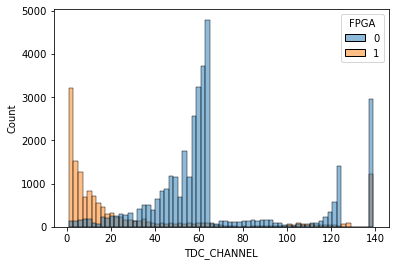

In [26]:
# plot number of counts per TDC channel
sns.histplot(data2, x = 'TDC_CHANNEL', hue = 'FPGA')
plt.show()

#### 8)

In [29]:
# Use the groupby method to find out the noisy channels
data_group = data2.groupby(['TDC_CHANNEL', 'FPGA'], as_index=False).count()
print(data_group.head(), '\n')

sort = data_group.sort_values(by = 'HEAD', ascending = False)
sort = sort.loc[:, ['TDC_CHANNEL', 'FPGA', 'HEAD']].rename(columns = {'HEAD' : 'COUNTS'})
print('Noisy channels for FPGA 0:\n', sort[sort['FPGA'] == 0].iloc[:3, :], '\n')
print('Noisy channels for FPGA 1:\n',sort[sort['FPGA'] == 1].iloc[:3, :], '\n')

   TDC_CHANNEL  FPGA  HEAD  ORBIT_CNT  BX_COUNTER  TDC_MEAS  TIME
0            1     0    39         39          39        39    39
1            1     1  1064       1064        1064      1064  1064
2            2     0    41         41          41        41    41
3            2     1  1268       1268        1268      1268  1268
4            3     0    65         65          65        65    65 

Noisy channels for FPGA 0:
      TDC_CHANNEL  FPGA  COUNTS
249          139     0    2966
117           63     0    2409
119           64     0    2381 

Noisy channels for FPGA 1:
      TDC_CHANNEL  FPGA  COUNTS
3              2     1    1268
250          139     1    1218
1              1     1    1064 



#### 9)

In [31]:
# unique orbits
unique = data['ORBIT_CNT'].nunique()
print('Number of unique orbits:', unique)

# unique orbit channel 139
unique_139 = data[data['TDC_CHANNEL'] == 139]['ORBIT_CNT'].nunique()
print('Number of unique orbits with at least one measurement from channel 139:', unique_139)

Number of unique orbits: 995
Number of unique orbits with at least one measurement from channel 139: 994
